In [1]:
import h5py
from scipy.stats import poisson
from scipy.special import factorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/dneise/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ls

crosstalk_thoughts.ipynb                 performance_of_correction.png
crosstalk_vs_rate.jpg                    plots_from_jens/
foo.png                                  poisson_correction.ipynb
foo.svg                                  README.md
formula_foo.png                          single_pe_spectra.hdf
gedankenexperiment_with_crosstalk.ipynb  Untitled2.ipynb
papers/


In [3]:
input_file_path = './single_pe_spectra.hdf'

In [4]:
with h5py.File(input_file_path) as f:
    keys = list(f.keys())
    print(*keys, sep=" | ")

Baseline | Chi2 | CoeffR | Crosstalk | FitProb | Gain | Noise | NormGain | Pxtalk | Rate | RelSigma | Signal


In [5]:
R = pd.read_hdf(input_file_path, key='Rate')
p = pd.read_hdf(input_file_path, key='Pxtalk')
nu = pd.read_hdf(input_file_path, key='CoeffR')
p_xt = pd.read_hdf(input_file_path, key='Crosstalk')

In [6]:
t_0 = 7e-9  # the effective integration window. We could somehow get this number from data, I think...
Nmax = 20

In [7]:
mu = R * 1e6 * t_0
q = p * np.exp(-p)

In [8]:
P_mu = poisson.pmf(k=np.arange(0, Nmax)[:, None], mu=mu)

In [9]:
def calc_Pn(N, q, nu):
    Ns = np.atleast_1d(N)
    result = np.zeros((len(N), q.shape[1]))
    for i, N in enumerate(Ns):
         result[i] = (q*N)**(N-1) / (factorial(N-1))**nu
    return result

In [10]:
Ns = np.arange(1, Nmax+1)
Pn = calc_Pn(Ns, q, nu)

In [11]:
Pn.shape, P_mu.shape

((20, 1440), (20, 1440))

In [12]:
Pn /= Pn.sum(axis=0)

In [13]:
Foo = Pn - P_mu

In [14]:
p_xt

,,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
night,run_id,,,,,,,,,,,,,,,,,,,,,
2017-12-23,0,0.146648,0.150309,0.13104,0.130837,0.146146,0.136665,0.16946,0.172331,0.140599,0.122513,...,0.132108,0.13999,0.166443,0.127064,0.160327,0.168607,0.144601,0.172661,0.153444,0.154155


In [15]:
Pn[1:].sum(axis=0) - p_xt

,,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
night,run_id,,,,,,,,,,,,,,,,,,,,,
2017-12-23,0,9.381642e-10,-2.369956e-09,-9.820424e-10,5.589326e-09,-4.397253e-10,-1.242334e-08,-5.901584e-09,5.153019e-09,1.308889e-08,-4.687315e-09,...,-6.196588e-09,-2.269467e-09,2.759441e-09,7.791574e-07,-1.280573e-09,0.000027,1.241569e-07,2.776807e-07,1.104640e-08,-5.316278e-09


In [16]:
p_ct_corrected = Foo[1:].sum(axis=0) / Pn.sum(axis=0)
p_ct_corrected

array([0.1174864 , 0.11970776, 0.10049618, ..., 0.1468643 , 0.12508215,
       0.12724501])

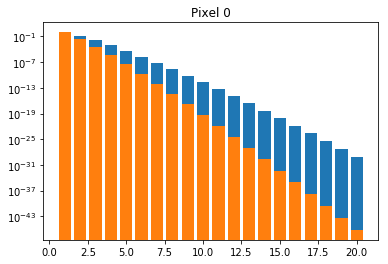

In [17]:
plt.bar(Ns, Pn[:, 0], log=True, label='Pn')
plt.bar(Ns, P_mu[:, 0], log=True, label='P_mu')
plt.title("Pixel 0");